In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Download NLTK data
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\AYUSH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AYUSH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
def preprocess_data(file_path):
    """Load and preprocess the dataset."""
    df = pd.read_csv(file_path)

    # Rename columns
    df.columns = ['ID', 'Game', 'Sentiment', 'Tweet']
    
    # Drop duplicates and NA values
    df = df.drop_duplicates().dropna()

    # Tokenization
    df['tokens'] = df['Tweet'].apply(word_tokenize)

    # Label encoding
    le = LabelEncoder()
    df['Sentiment'] = le.fit_transform(df['Sentiment'])

    return df, le

In [4]:
def build_vocab(tokenized_texts):
    """Build vocabulary and mapping functions."""
    vocab = {word for tokens in tokenized_texts for word in tokens}
    word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab)}  # Start indexing at 1
    word_to_idx['<PAD>'] = 0  # Padding index

    return word_to_idx

In [5]:
def encode_text(tokens, word_to_idx, max_len):
    """Encode tokens to integers and pad sequences."""
    encoded = [word_to_idx.get(token, 0) for token in tokens]  # Use 0 for unknown words
    padded = encoded[:max_len] + [0] * max(0, max_len - len(encoded))
    return padded

In [6]:
class TwitterDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [7]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        hidden = hidden.squeeze(0)
        out = self.fc(hidden)
        return out

In [8]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs):
    """Train the model."""
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for texts, labels in tqdm(train_loader):
            texts, labels = texts.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(texts)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        average_train_loss = train_loss / len(train_loader)
        train_losses.append(average_train_loss)

        # Evaluate on validation set
        val_accuracy = evaluate_model(model, val_loader)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}, Training Loss: {average_train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, val_accuracies

In [9]:
def evaluate_model(model, loader):  
    """Evaluate the model."""
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            output = model(texts)
            preds = torch.argmax(output, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    return acc

In [10]:
def plot_results(train_losses, val_accuracies):
    """Plot training loss and validation accuracy."""
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.title('Training Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Validation Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [11]:
def main():
    train_path = 'E:/jupyter/practice4/twitter_training.csv'  
    val_path = 'E:/jupyter/practice4/twitter_validation.csv'  

    # Preprocess training and validation data
    train_df, le = preprocess_data(train_path)
    val_df, _ = preprocess_data(val_path)

    # Build vocabulary
    word_to_idx = build_vocab(train_df['tokens'])
    max_len = 50  # Maximum sequence length

    # Encode text
    train_df['encoded'] = train_df['tokens'].apply(lambda x: encode_text(x, word_to_idx, max_len))
    val_df['encoded'] = val_df['tokens'].apply(lambda x: encode_text(x, word_to_idx, max_len))

    # Prepare datasets and loaders
    train_dataset = TwitterDataset(list(train_df['encoded']), list(train_df['Sentiment']))
    val_dataset = TwitterDataset(list(val_df['encoded']), list(val_df['Sentiment']))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Model and training setup
    vocab_size = len(word_to_idx)
    embed_dim = 128
    hidden_dim = 64
    output_dim = len(le.classes_)
    pad_idx = word_to_idx['<PAD>']

    model = SentimentModel(vocab_size, embed_dim, hidden_dim, output_dim, pad_idx).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    train_losses, val_accuracies = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5)

    # Save the model
    torch.save(model.state_dict(), 'sentiment_model.pth')
    print("Model saved successfully!")

    # Plot results
    plot_results(train_losses, val_accuracies)

    # Evaluate on validation set for confusion matrix
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device), labels.to(device)
            output = model(texts)
            preds = torch.argmax(output, dim=1)

            val_predictions.extend(preds.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(val_true_labels, val_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [12]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

100%|██████████████████████████████████████████████████████████████████████████████| 2240/2240 [01:49<00:00, 20.49it/s]


Epoch 1, Training Loss: 1.3346, Validation Accuracy: 0.4484


100%|██████████████████████████████████████████████████████████████████████████████| 2240/2240 [02:11<00:00, 17.01it/s]


Epoch 2, Training Loss: 1.0914, Validation Accuracy: 0.6717


100%|██████████████████████████████████████████████████████████████████████████████| 2240/2240 [02:08<00:00, 17.44it/s]


Epoch 3, Training Loss: 0.7592, Validation Accuracy: 0.8438


100%|██████████████████████████████████████████████████████████████████████████████| 2240/2240 [02:08<00:00, 17.39it/s]


Epoch 4, Training Loss: 0.4788, Validation Accuracy: 0.9059


100%|██████████████████████████████████████████████████████████████████████████████| 2240/2240 [02:39<00:00, 14.00it/s]


Epoch 5, Training Loss: 0.3107, Validation Accuracy: 0.9299
Model saved successfully!


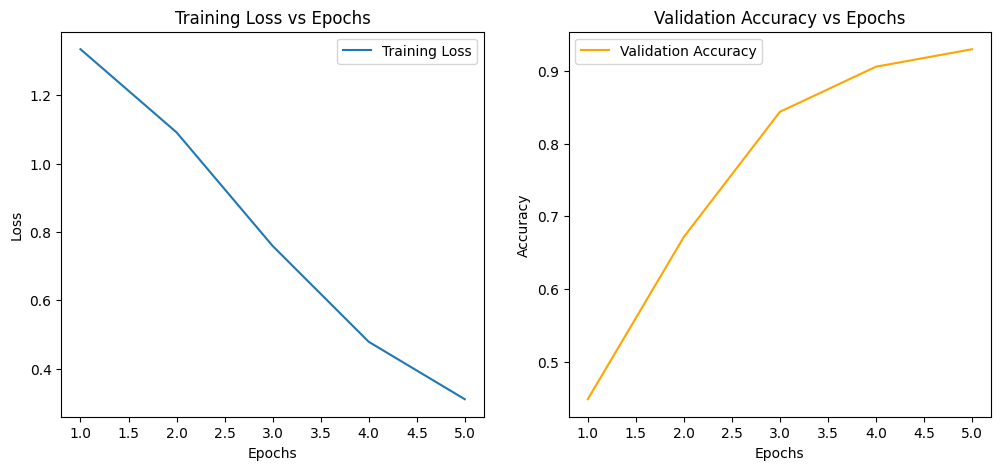

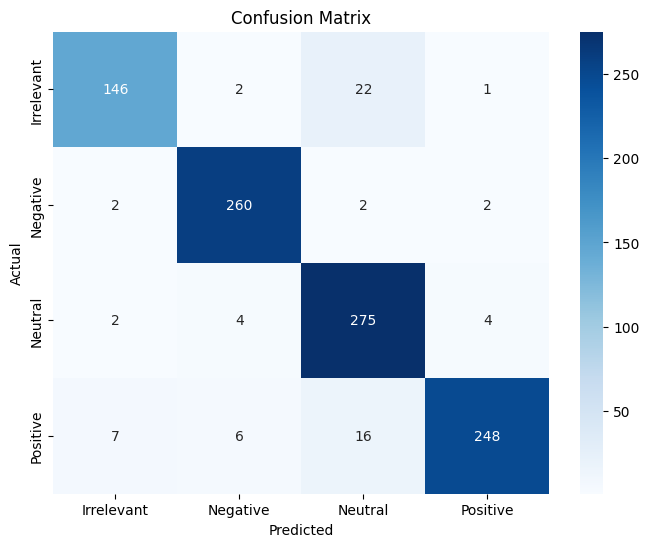

In [13]:
if __name__ == "__main__":
    main()